<a href="https://colab.research.google.com/github/anirbanl/jax-code/blob/master/rlflax/qlearning/jax_flax_dueling_dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on sources:

1. https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1
2. https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
3. https://medium.com/@parsa_h_m/deep-reinforcement-learning-dqn-double-dqn-dueling-dqn-noisy-dqn-and-dqn-with-prioritized-551f621a9823
4. https://github.com/higgsfield/RL-Adventure/blob/master/3.dueling%20dqn.ipynb

In [ ]:
!pip install jax jaxlib flax

     |████████████████████████████████| 184kB 8.1MB/s 
     |████████████████████████████████| 122kB 26.8MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 


In [ ]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import jax
import jax.numpy as jp
from jax.ops import index, index_add, index_update
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd, value_and_grad
from functools import partial
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state
import optax                           # Optimizers
from typing import Sequence, Type

In [ ]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, key, batch_size):
        key, _ = jax.random.split(key)
        idx = jax.random.choice(key,
                               jp.arange(len(self.buffer)), 
                               shape=(batch_size, ))
        # print(f"\nIds:{jp.mean(idx)}\n")
        return [self.buffer[ii] for ii in idx]

In [ ]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [ ]:
#Define Q-network
class QNetwork:
    def __init__(self, rng, env, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        self.key = rng
        self.env = env
        # print(f"QNetwork rng:{rng}")

        class Sequential(nn.Module):
            layers: Sequence[nn.Module]

            @nn.compact
            def __call__(self, x):
                for layer in self.layers:
  	                x = layer(x)
                return x

        feature_model = Sequential(
            layers = [nn.Dense(hidden_size), nn.relu]
        )
        advantage_model = Sequential(
            layers = [nn.Dense(hidden_size), nn.relu, nn.Dense(action_size)]
        )
        value_model = Sequential(
            layers = [nn.Dense(hidden_size), nn.relu, nn.Dense(1)]
        )

        class DuelingDoubleDQN(nn.Module):

            @nn.compact
            def __call__(self, x):
                rng = jax.random.PRNGKey(1)
                feature_params = feature_model.init(rng, jp.ones((state_size, )))
                x = feature_model.apply(feature_params, x)

                advantage_params = advantage_model.init(rng, jp.ones((hidden_size, )))
                advantage = advantage_model.apply(advantage_params, x)

                value_params = value_model.init(rng, jp.ones((hidden_size, )))
                value = value_model.apply(value_params, x)

                return value + advantage - jp.mean(advantage)

        def create_train_state(rng, learning_rate, input_size):
            """Creates initial `TrainState`."""
            model = DuelingDoubleDQN()
            params = model.init(rng, jp.ones((input_size, )))#['params']
            tx = optax.adam(learning_rate)
            return train_state.TrainState.create(
                apply_fn=model.apply, params=params, tx=tx)

        self.ts = create_train_state(rng, learning_rate, state_size)

        @jit
        def train_step(ts, inputs, actions, targets):

            def loss_fun(params, inputs, actions, targets):
                output = ts.apply_fn(params, inputs)
                selectedq = jp.sum(actions*output, axis=-1)
                diff = selectedq - jax.lax.stop_gradient(targets)
                return jp.mean(diff**2)

            loss, g = value_and_grad(loss_fun)(ts.params, inputs, actions, targets)
            return ts.apply_gradients(grads=g), loss

        self.train_fn = train_step


    def act(self, state, explore_p):
        self.key, _ = jax.random.split(self.key)
        # print(f"Act key:{self.key}")
        uf = jax.random.uniform(self.key, (1,), minval=0.0, maxval=1.0)[0]
        if explore_p > uf:
            # Make a random action
            action = self.env.action_space.sample()
        else:
            # Get action from Q-network
            qvalues = self.ts.apply_fn(self.ts.params, state)
            action = jp.argmax(qvalues).item()
        return action


In [ ]:
def init_memory(env):
    # Initialize the simulation
    env.reset()
    # Take one random step to get the pole and cart moving
    state, reward, done, _ = env.step(env.action_space.sample())
    # print(f"@@@@@@ Env init state:{state} @@@@@@")

    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):
        # Uncomment the line below to watch the simulation
        # env.render()

        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        # print(f"@@@@@@ Env action:{action} @@@@@@")
        # print(f"@@@@@@ Env next state:{next_state} @@@@@@")

        if done:
            # The simulation fails so no next state
            next_state = jp.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            
            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
    return memory, state

In [ ]:
# Now train with experiences
def one_hot(x, k, dtype=jp.float32):
  """Create a one-hot encoding of x of size k."""
  return jp.array(x[:, None] == jp.arange(k), dtype)


def train(rng, env, mainQN):
    # print(f"train rng:{rng}")
    rewards_list = []    
    step = 0
    memory, state = init_memory(env)
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*jp.exp(-decay_rate*step) 
            action = mainQN.act(state, explore_p)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            # print(f"State:{state}")
            # print(f"Reward:{reward}")
            # print(f"Action:{action}")
            # print(f"Done:{done}\n")

            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = jp.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                    'Total reward: {}'.format(total_reward),
                    'Training loss: {:.4f}'.format(loss),
                    'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(rng, batch_size)
            states = jp.array([each[0] for each in batch])
            actions = one_hot(jp.array([each[1] for each in batch]), 2)
            rewards = jp.array([each[2] for each in batch])
            next_states = jp.array([each[3] for each in batch])
            
            # Train network
            target_Qs = mainQN.ts.apply_fn(mainQN.ts.params, next_states)
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == jp.zeros(states[0].shape)).all(axis=1)
            new_target_Qs = index_update(target_Qs, index[episode_ends], (0, 0))
            target_Qs = new_target_Qs
            
            targets = rewards + gamma * jp.max(target_Qs, axis=1)
            # print(states.shape, targets.shape, targets)
            mainQN.ts, loss = mainQN.train_fn(mainQN.ts, states, actions, targets)

    return rewards_list

def plot_scores(rewards_list):
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.plot(eps, rews, color='grey', alpha=0.3)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: 2
Episode: 1 Total reward: 31.0 Training loss: 1.8259 Explore P: 0.9969
Episode: 2 Total reward: 54.0 Training loss: 1.7116 Explore P: 0.9916
Episode: 3 Total reward: 28.0 Training loss: 2.2000 Explore P: 0.9889
Episode: 4 Total reward: 21.0 Training loss: 1.5221 Explore P: 0.9868
Episode: 5 Total reward: 8.0 Training loss: 1.6395 Explore P: 0.9860
Episode: 6 Total reward: 13.0 Training loss: 2.3222 Explore P: 0.9848
Episode: 7 Total reward: 20.0 Training loss: 1.7800 Explore P: 0.9828
Episode: 8 Total reward: 35.0 Training loss: 2.0489 Explore P: 0.9794
Episode: 9 Total reward: 27.0 Training loss: 2.1992 Explore P: 0.9768
Episode: 10 Total reward: 22.0 Training loss: 1.9105 Explore P: 0.9747
Episode: 11 Total reward: 15.0 Training loss: 2.5201 Explore P: 0.9732
Episode: 12 Total reward: 28.0 Training loss: 2.4345 Explore P: 0.9705
Episode: 13 Total reward: 10.0 Training loss: 2.9751 Ex

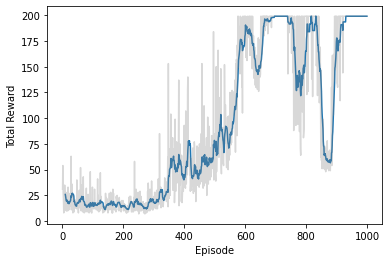

In [ ]:
def main():
    seed = 0
    env = gym.make('CartPole-v0')
    env.seed(seed)
    env.action_space.seed(seed)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space.n)
    rng = jax.random.PRNGKey(seed)
    mainQN = QNetwork(rng, env, name='main', hidden_size=hidden_size, learning_rate=learning_rate)
    rewards_list = train(rng, env, mainQN)
    plot_scores(rewards_list)

if __name__ == '__main__':
    main()